## Wild Blueberry Harvest Predictions
Anton Young

This notebook is for Kaggle's Prediction of Wild Blueberry Yield playground competition. It will cover the data visualization, data preprocessing, training, and evaluating several different scikit learn models using sklearn Pipeline.

In [35]:
# Relevant Library Imports

import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/playground-series-s3e14/sample_submission.csv
/kaggle/input/playground-series-s3e14/train.csv
/kaggle/input/playground-series-s3e14/test.csv


## About the data
The Wild blueberry Yield Prediction Dataset, available at https://www.kaggle.com/datasets/shashwatwork/wild-blueberry-yield-prediction-dataset, is a artificially-generated dataset from the Wild Blueberry Pollination Simulation Model, which can be used to understand the influence of factors on actual wild blueberry crop yields. 

There are 16 predictive features (`id`s are assigned arbitrarily), with `yield` as the target feature.

Features and their descriptions:

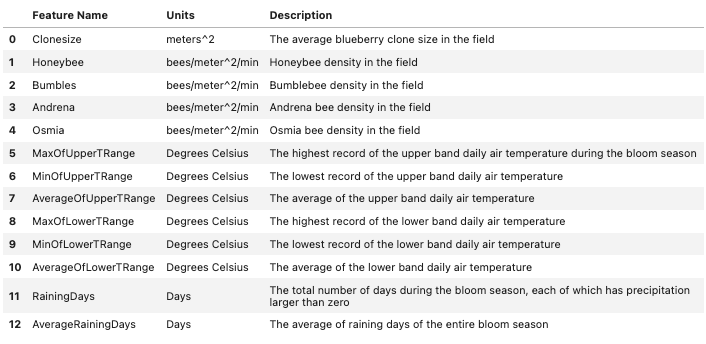

The features `fruitset`, `fruitmass`, and `seeds` are not given a description at the provided link, and by their names, seem as if they are correlated with `yield`. We will explore this relationship below.

In [36]:
#Importing the train and test data from the competition dataset
train_data = pd.read_csv('/kaggle/input/playground-series-s3e14/train.csv')
test_data = pd.read_csv('/kaggle/input/playground-series-s3e14/test.csv')

In [37]:
train_data.head()

,id,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
0,0,25.0,0.50,0.25,0.75,0.50,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.425011,0.417545,32.460887,4476.81146
1,1,25.0,0.50,0.25,0.50,0.50,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.444908,0.422051,33.858317,5548.12201
2,2,12.5,0.25,0.25,0.63,0.63,86.0,52.0,71.9,62.0,30.0,50.8,24.0,0.39,0.552927,0.470853,38.341781,6869.77760
3,3,12.5,0.25,0.25,0.63,0.50,77.4,46.8,64.7,55.8,27.0,45.8,24.0,0.39,0.565976,0.478137,39.467561,6880.77590
4,4,25.0,0.50,0.25,0.63,0.63,77.4,46.8,64.7,55.8,27.0,45.8,24.0,0.39,0.579677,0.494165,40.484512,7479.93417


In [38]:
#Shape returns (number of examples, number of features)
print("Shape of Training Data")
print(train_data.shape)
#dtypes tell us what preprocessing is required for each feature
print("Feature Data Types")
print(train_data.dtypes)
#How many missing values are in each column?
print("Missing Values by Feature")
print(train_data.isna().sum())

Shape of Training Data
(15289, 18)
Feature Data Types
id                        int64
clonesize               float64
honeybee                float64
bumbles                 float64
andrena                 float64
osmia                   float64
MaxOfUpperTRange        float64
MinOfUpperTRange        float64
AverageOfUpperTRange    float64
MaxOfLowerTRange        float64
MinOfLowerTRange        float64
AverageOfLowerTRange    float64
RainingDays             float64
AverageRainingDays      float64
fruitset                float64
fruitmass               float64
seeds                   float64
yield                   float64
dtype: object
Missing Values by Feature
id                      0
clonesize               0
honeybee                0
bumbles                 0
andrena                 0
osmia                   0
MaxOfUpperTRange        0
MinOfUpperTRange        0
AverageOfUpperTRange    0
MaxOfLowerTRange        0
MinOfLowerTRange        0
AverageOfLowerTRange    0
RainingDays       

This data is very easy to work with, as everything is numerically represented, and there are no missing values for any of the features. If there were string (object) features, we would need to encode them, and if there were missing features, we would need to remove them or impute values.





## Understanding Our Data (EDA)

`fruitset`, `fruitmass`, and `seeds` all seem like they should be positively correlated with `yield`. Let's test that hypothesis by creating a correlation matrix:

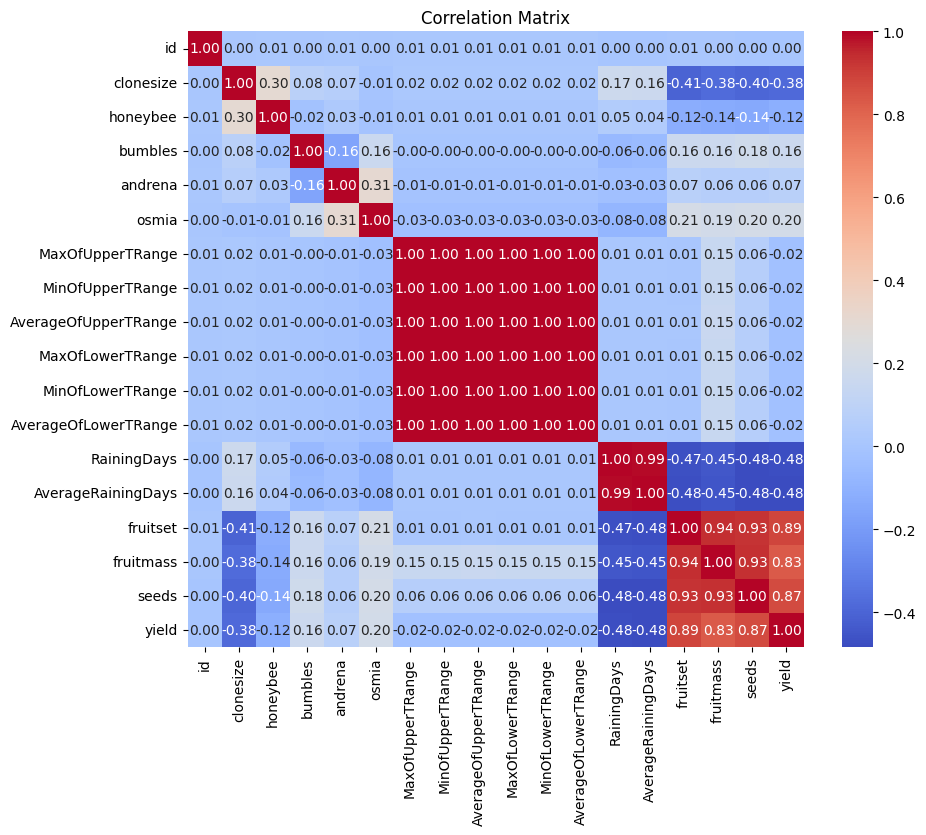

In [39]:
# Calculate correlations
corr = train_data.corr()

# Create a heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)

plt.title("Correlation Matrix")
plt.show()

A correlation matrix is useful for detecting linear dependencies between features in our dataset. Values close to 1 and -1 indicate strong correlations, and values close to 0 have weak/no correlation.

This correlation matrix detected several redundant features. All of the `TRange...` features are perfectly correlated, so all but one can be safely removed without losing information.

`RainingDays` and `AverageRaningDays` have a correlation of .99, so we can remove one of those as well.

`clonesize`, `RainingDays`, and `AverageRainingDays` have moderate negative correlations with `fruitset`, `fruimass`, `seeds`, and `yield`.

`fruitset`, `fruitmass`, and `seeds`, are highly correlated with `yield`, so these alone can give us a good estimate of `yield`. However, because they are also highly correlated with each other, there is likely a good amount of redundant information between the features. 

In [40]:
print(train_data.nunique())

id                      15289
clonesize                   6
honeybee                    7
bumbles                    11
andrena                    16
osmia                      14
MaxOfUpperTRange            6
MinOfUpperTRange            5
AverageOfUpperTRange        5
MaxOfLowerTRange            6
MinOfLowerTRange            7
AverageOfLowerTRange        5
RainingDays                 6
AverageRainingDays          8
fruitset                 1526
fruitmass                1515
seeds                    2066
yield                     776
dtype: int64


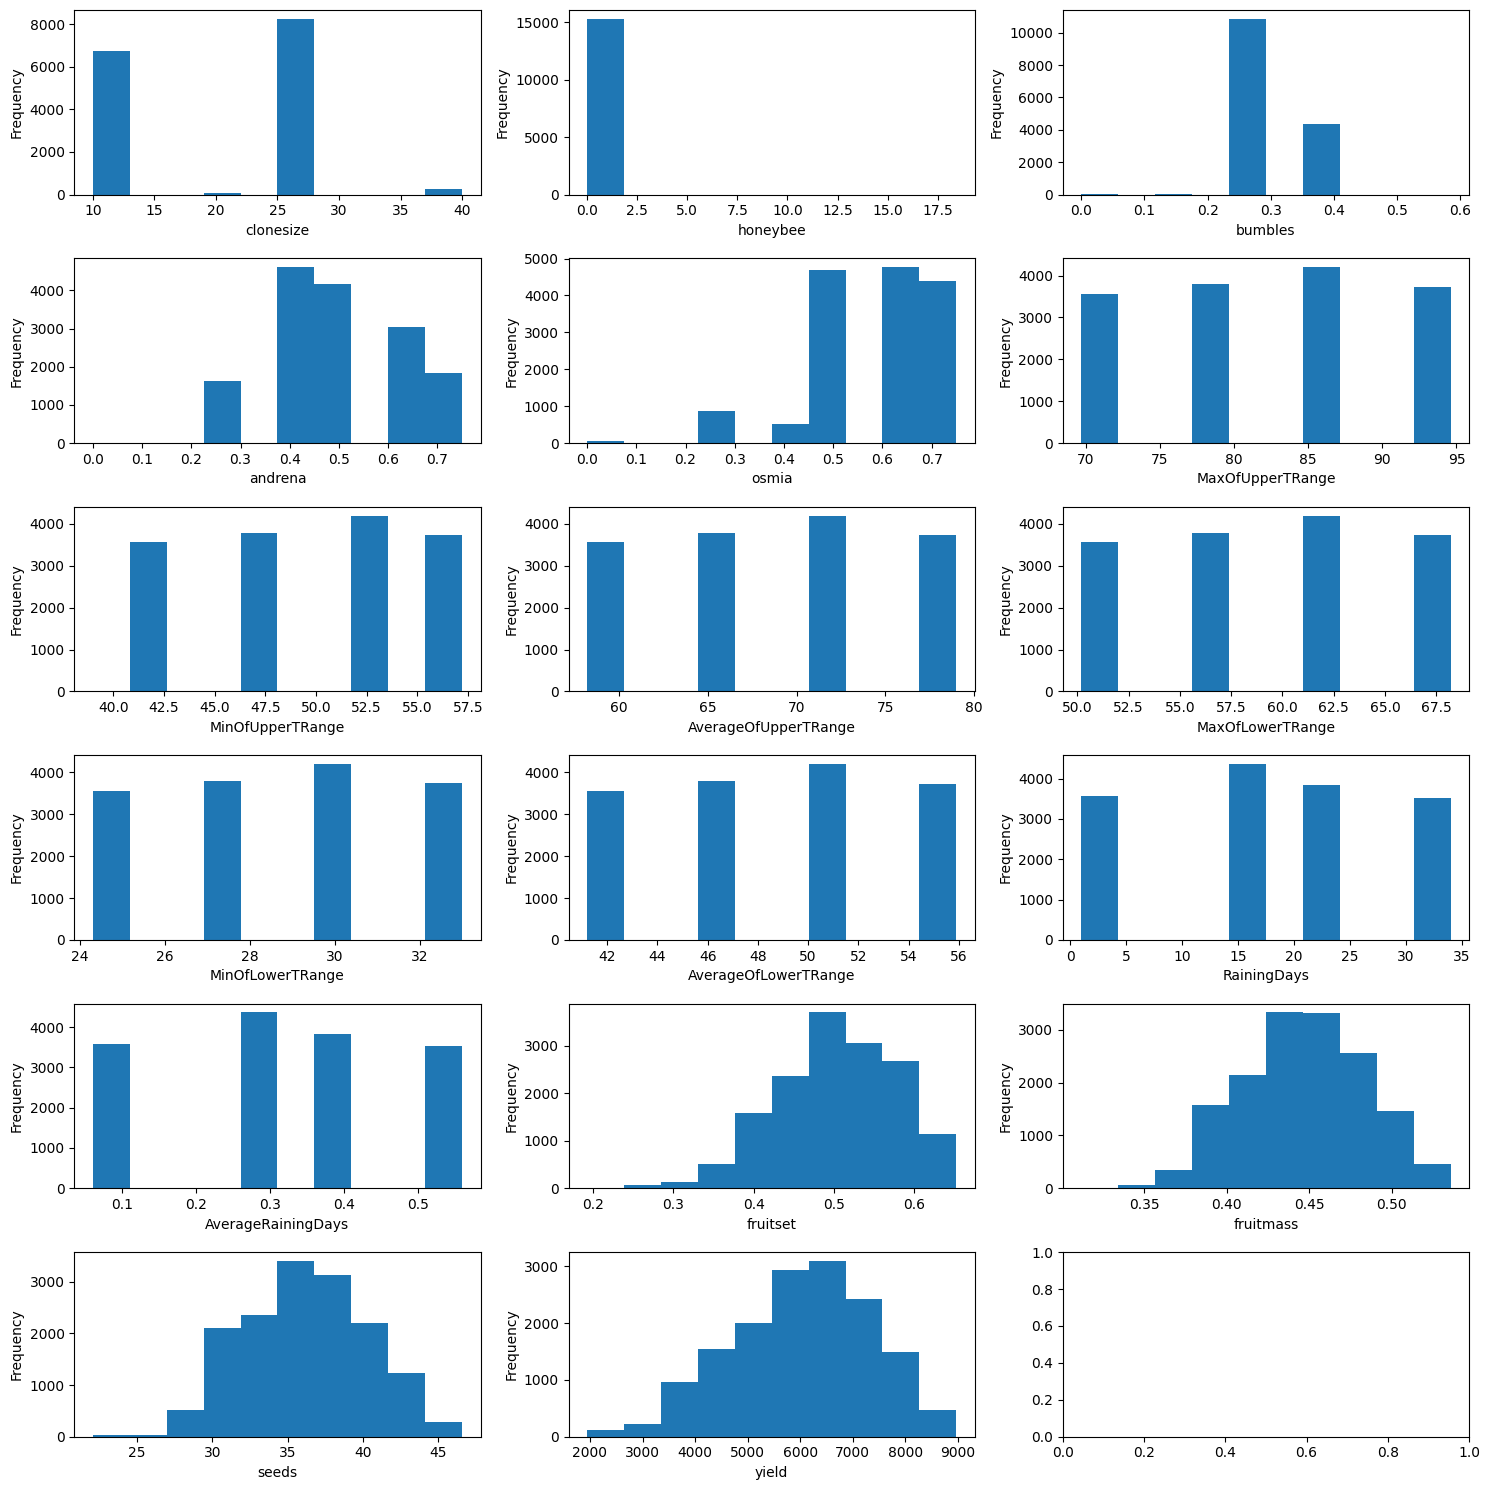

In [41]:

fig, axs = plt.subplots(int(len(train_data.columns[1:]) // 3 + 1), 3, figsize=(15, 15))

current_ax = 0
for feature in train_data.columns[1:]:
    row = current_ax // 3
    col = current_ax % 3
    axs[row, col].hist(train_data[feature])
    axs[row, col].set_xlabel(feature)
    axs[row, col].set_ylabel("Frequency")
    current_ax += 1

plt.tight_layout()
plt.show()

Now let's look at outliers of the data. We generally want to avoid outliers when training our model, because including them can influence the mean and variance of the features they belong to, and make our model more prone to overfitting.

In [42]:
for column in train_data.columns[1:]:
    Q1 = train_data[column].quantile(0.25)
    Q3 = train_data[column].quantile(0.75)
    IQR = Q3 - Q1
    small_outlier = Q1 - 1.5 * IQR
    large_outlier = Q3 + 1.5 * IQR
    num_outliers = sum(train_data[column] > large_outlier) + sum(train_data[column] < small_outlier)
    print("Feature", column, "has", num_outliers, "outliers")

Feature clonesize has 0 outliers
Feature honeybee has 8 outliers
Feature bumbles has 10 outliers
Feature andrena has 8 outliers
Feature osmia has 56 outliers
Feature MaxOfUpperTRange has 0 outliers
Feature MinOfUpperTRange has 0 outliers
Feature AverageOfUpperTRange has 0 outliers
Feature MaxOfLowerTRange has 0 outliers
Feature MinOfLowerTRange has 0 outliers
Feature AverageOfLowerTRange has 0 outliers
Feature RainingDays has 3569 outliers
Feature AverageRainingDays has 49 outliers
Feature fruitset has 97 outliers
Feature fruitmass has 23 outliers
Feature seeds has 24 outliers
Feature yield has 26 outliers


The dataset has a few outliers, so I'm going to use RobustScaler in my preprocessing pipeline which should help reduce the impact that those outliers have on the models.

In [43]:

drop_cols = ['MaxOfUpperTRange', 'MinOfUpperTRange', 'MaxOfLowerTRange', 
             'MinOfLowerTRange', 'AverageOfLowerTRange']

#Split into X and y
X = train_data.drop(['yield','id'], axis=1)
y = train_data['yield']

#train test split for validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)

Using a pipeline for the preprocessing + model

In [44]:

models = []
results = []

np.random.seed(1)
columns = X_train.columns

num_transformer = Pipeline(steps=[
    ('scaler', RobustScaler())
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, columns),
        ('drop', 'drop', drop_cols)
    ])


Now we can use it for linear regression:

In [45]:
#('drop', 'drop', drop_cols)
pipeline_Linear = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LinearRegression())])

pipeline_Linear.fit(X_train, y_train)
y_pred = pipeline_Linear.predict(X_val)

lr_mae = mean_absolute_error(y_val, y_pred)

models.append("Linear Regression")
results.append(lr_mae)

 And K-nearest-neighbors:

In [46]:

pipeline_KNN = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', KNeighborsRegressor())])

pipeline_KNN.fit(X_train, y_train)
y_pred = pipeline_KNN.predict(X_val)

knn_mae = mean_absolute_error(y_val, y_pred)

models.append("KNN")
results.append(knn_mae)

And random forest:

In [47]:

pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', RandomForestRegressor(oob_score=True))])

pipeline_rf.fit(X_train, y_train)
y_pred = pipeline_rf.predict(X_val)

mae_rf = mean_absolute_error(y_val, y_pred)

Random forest shows promise, let's run a grid search on the hyperparameters

In [48]:

param_grid= { 'regressor__n_estimators': range(30, 80, 10),
             'regressor__max_depth': range(4, 10,1)}

grid_search_rf = GridSearchCV(pipeline_rf, param_grid, cv=5)

grid_search_rf.fit(X_train, y_train)

best_params = grid_search_rf.best_params_
print("Best hyperparameters:", best_params)
best_rf_pipeline = grid_search_rf.best_estimator_
best_rf_pipeline.fit(X_train, y_train)

y_pred = best_rf_pipeline.predict(X_val)
mae_rf_grid = mean_absolute_error(y_val, y_pred)

models.append("Random Forest")
results.append(mae_rf_grid)

Best hyperparameters: {'regressor__max_depth': 7, 'regressor__n_estimators': 70}


Also trying multilayer perceptron

In [49]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

pipeline_MLP = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', MLPRegressor([32,16,16], warm_start = True, max_iter=1))])

#pipeline_MLP.fit(X_train, y_train)

training_loss = []
validation_loss = []

#Using warm_start = True means every call to model.fit() runs 1 epoch
for _ in range(100):
    pipeline_MLP.fit(X_train, y_train)
    train_loss = pipeline_MLP.named_steps['regressor'].loss_curve_[-1]
    training_loss.append(train_loss)
    
    preds = pipeline_MLP.predict(X_val)
    val_loss = mean_squared_error(y_val, preds)
    validation_loss.append(val_loss)
    
y_pred = pipeline_MLP.predict(X_val)

mlp_mae = mean_absolute_error(y_val, y_pred)

models.append("Neural Network")
results.append(mlp_mae)

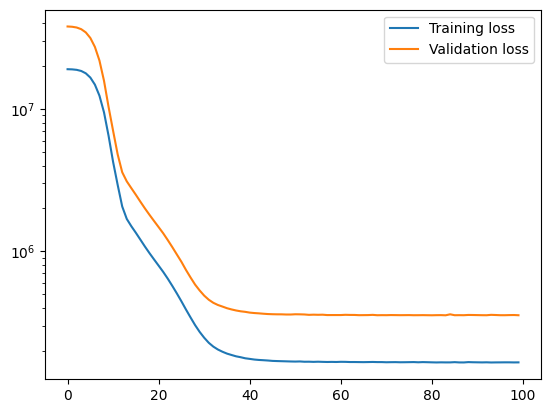

In [50]:
plt.plot(pipeline_MLP.named_steps['regressor'].loss_curve_, label='Training loss')
plt.plot(validation_loss, label='Validation loss')
plt.yscale('log')
plt.legend()
plt.show()

Finally, xgboost and grid search

In [51]:
from xgboost import plot_importance, XGBRegressor

pipeline_XGB = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', XGBRegressor())])

param_grid= { 'regressor__learning_rate': [0.01, 0.1,0.3],
             'regressor__max_depth': range(3, 10,1)}

grid_search_XGB = GridSearchCV(pipeline_XGB, param_grid, cv=5)

grid_search_XGB.fit(X_train, y_train)

best_params = grid_search_XGB.best_params_
print("Best hyperparameters:", best_params)
best_XGB_pipeline = grid_search_XGB.best_estimator_
best_XGB_pipeline.fit(X_train, y_train)

y_pred = best_XGB_pipeline.predict(X_val)
mae_XGB_grid = mean_absolute_error(y_val, y_pred)

models.append("XGBoost")
results.append(mae_XGB_grid)

Best hyperparameters: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 5}


## Model Evaluation

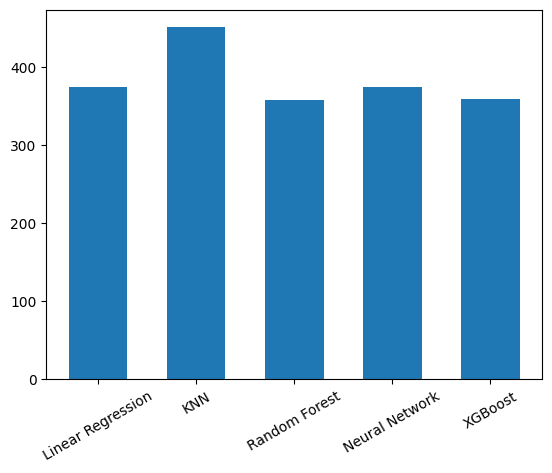

In [52]:
plt.bar(x=models, height=results, width=0.6)
plt.xticks(rotation=30)
plt.show()

Analysis of the best performing model on the validation set (random forest):


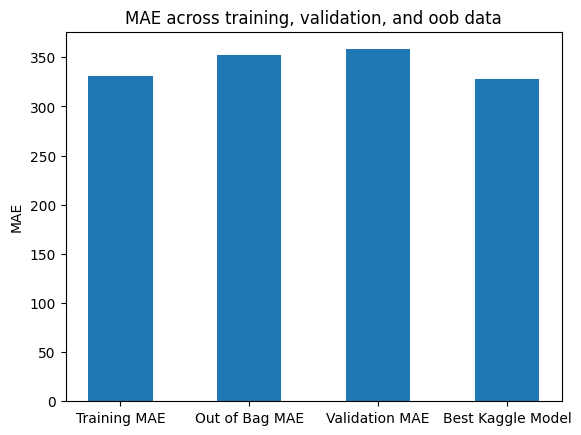

In [53]:
train_preds = best_rf_pipeline.predict(X_train)
train_mae = mean_absolute_error(y_train, train_preds)
oob_predictions = best_rf_pipeline.named_steps['regressor'].oob_prediction_
oob_mae = mean_absolute_error(y_train, oob_predictions)
plt.bar(x=["Training MAE", "Out of Bag MAE", "Validation MAE", "Best Kaggle Model"], height=[train_mae, oob_mae, mae_rf_grid, 327.387], width=0.5)
plt.title("MAE across training, validation, and oob data")
plt.ylabel("MAE")
plt.show()

It seems like the grid search did a good job finding a local optima in the training set that generalized to unseen data (validation set). 

In [54]:
test_preds = best_rf_pipeline.predict(test_data)

In [55]:
submission = pd.DataFrame({"id":test_data['id'], "yield":test_preds})

In [56]:
submission.to_csv('submission.csv', index=False)

In [57]:
submission.head()

,id,yield
0,15289,4306.476740
1,15290,6060.610853
2,15291,7205.437671
3,15292,4661.296293
4,15293,3789.264023
